This notebook is a small exercise to practice exploring and visualizing data. 

**Objective:**

1. Is there any relationship between the Rotten Tomatoes ratings and those from IMDb?
2. Are there any insights to be gleaned from analyzing the lengths of the movies?
3. Is there a relationship between the number of enemies James Bond has killed and the user ratings of the movie in which they were killed?

### Install libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Load data

In [2]:
# We have already acquired the data, so we simply need to load it.
df = pd.read_csv('data/james_bond_data.csv').convert_dtypes()

In [3]:
# Take a look at the first few rows of the data.
df.head()

,Release,Movie,Bond,Bond_Car_MFG,US_Gross,World_Gross,Budget ($ 000s),Film_Length,Avg_User_IMDB,Avg_User_Rtn_Tom,Martinis,Kills_Bond
0,"June, 1962",Dr. No,Sean Connery,Sunbeam,"$16,067,035.00","$59,567,035.00","$1,000.00",110 mins,7.3,7.7,2,4
1,"August, 1963",From Russia with Love,Sean Connery,Bentley,"$24,800,000.00","$78,900,000.00","$2,000.00",115 mins,7.5,8.0,0,11
2,"May, 1964",Goldfinger,Sean Connery,Aston Martin,"$51,100,000.00","$124,900,000.00","$3,000.00",110 mins,7.8,8.4,1,9
3,"September, 1965",Thunderball,Sean Connery,Aston Martin,"$63,600,000.00","$141,200,000.00","$9,000.00",130 mins,7.0,6.8,0,20
4,"November, 1967",You Only Live Twice,Sean Connery,Toyota,"$43,100,000.00","$111,600,000.00","$9,500.00",117 mins,6.9,6.3,1,21


In [4]:
df.shape

(27, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Release           27 non-null     string 
 1   Movie             27 non-null     string 
 2   Bond              27 non-null     string 
 3   Bond_Car_MFG      27 non-null     string 
 4   US_Gross          27 non-null     string 
 5   World_Gross       27 non-null     string 
 6   Budget ($ 000s)   27 non-null     string 
 7   Film_Length       27 non-null     string 
 8   Avg_User_IMDB     26 non-null     Float64
 9   Avg_User_Rtn_Tom  26 non-null     Float64
 10  Martinis          27 non-null     Int64  
 11  Kills_Bond        27 non-null     Int64  
dtypes: Float64(2), Int64(2), string(8)
memory usage: 2.8 KB


### Clean data

#### Rename columns

In [6]:
# Start by renaming the columns to make them easier to work with. Create a dictionary with new names.
new_column_names = {
   "Release": "release_date",
   "Movie": "movie_title",
   "Bond": "bond_actor",
   "Bond_Car_MFG": "car_manufacturer",
   "US_Gross": "income_usa",
   "World_Gross": "income_world",
   "Budget ($ 000s)": "movie_budget",
   "Film_Length": "film_length",
   "Avg_User_IMDB": "imdb",
   "Avg_User_Rtn_Tom": "rotten_tomatoes",
   "Martinis": "martinis_consumed",
   "Kills_Bond": "bond_kills",
   }

data = df.rename(columns=new_column_names)

In [7]:
data.columns

Index(['release_date', 'movie_title', 'bond_actor', 'car_manufacturer',
       'income_usa', 'income_world', 'movie_budget', 'film_length', 'imdb',
       'rotten_tomatoes', 'martinis_consumed', 'bond_kills'],
      dtype='object')

#### Identify and fix missing values

In [8]:
data.isna().sum()

release_date         0
movie_title          0
bond_actor           0
car_manufacturer     0
income_usa           0
income_world         0
movie_budget         0
film_length          0
imdb                 1
rotten_tomatoes      1
martinis_consumed    0
bond_kills           0
dtype: int64

In [9]:
# Where are the missing values?
data.loc[data.isna().any(axis="columns")] # any row with a missing value

,release_date,movie_title,bond_actor,car_manufacturer,income_usa,income_world,movie_budget,film_length,imdb,rotten_tomatoes,martinis_consumed,bond_kills
10,"April, 1977",The Spy Who Loved Me,Roger Moore,Lotus,"$46,800,000.00","$185,400,000.00","$14,000.00",125 mins,<NA>,<NA>,1,31


#### Fix data types

##### Financial columns

In [10]:
data[
    ["income_usa", "income_world", "movie_budget", "film_length"]
    ].head()

,income_usa,income_world,movie_budget,film_length
0,"$16,067,035.00","$59,567,035.00","$1,000.00",110 mins
1,"$24,800,000.00","$78,900,000.00","$2,000.00",115 mins
2,"$51,100,000.00","$124,900,000.00","$3,000.00",110 mins
3,"$63,600,000.00","$141,200,000.00","$9,000.00",130 mins
4,"$43,100,000.00","$111,600,000.00","$9,500.00",117 mins


In [11]:
# Add the missing values and convert the data of income_usa to Float64.
data = (
    df.rename(columns=new_column_names)
    .combine_first(
        pd.DataFrame({"imdb": {10: 7.1}, "rotten_tomatoes": {10: 6.8}}))
    .assign(income_usa=lambda data: (data["income_usa"]
                                     .replace("[$,]", "", regex=True)
                                     .astype("Float64")
                                        ),
            income_world=lambda data: (data["income_world"]
                                        .replace("[$,]", "", regex=True)
                                        .astype("Float64")
                                         ),
            movie_budget=lambda data: (data["movie_budget"]
                                        .replace("[$,]", "", regex=True)
                                        .astype("Float64")
                                        .mul(1000) # convert to thousands
                                       ),
            film_length=lambda data: (data["film_length"]
                                        .str.removesuffix("mins")
                                        .astype("Int64")
                                        .replace(1200, 120)
                                      ),
            release_date=lambda data: (pd.to_datetime(data["release_date"],
                                                        format="%B, %Y")
                                      ),
            release_year=lambda data: (data["release_date"]
                                       .dt.year
                                       .astype("Int64")),
            bond_actor=lambda data: (data["bond_actor"]
                                     .str.replace("Shawn Connery", "Sean Connery")
                                     .str.replace("Roger MOORE", "Roger Moore")),
            car_manufacturer=lambda data: (data["car_manufacturer"]
                                        .str.replace("Astin Martin", "Aston Martin")),
            martinis_consumed=lambda data: (data["martinis_consumed"]
                                       .replace(-6, 6)),

        )
    )

data.drop_duplicates(inplace=True)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 0 to 26
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bond_actor         25 non-null     string        
 1   bond_kills         25 non-null     Int64         
 2   car_manufacturer   25 non-null     string        
 3   film_length        25 non-null     Int64         
 4   imdb               25 non-null     Float64       
 5   income_usa         25 non-null     Float64       
 6   income_world       25 non-null     Float64       
 7   martinis_consumed  25 non-null     Int64         
 8   movie_budget       25 non-null     Float64       
 9   movie_title        25 non-null     string        
 10  release_date       25 non-null     datetime64[ns]
 11  rotten_tomatoes    25 non-null     Float64       
 12  release_year       25 non-null     Int64         
dtypes: Float64(5), Int64(4), datetime64[ns](1), string(3)
memory usage: 3.0 

In [13]:
data.head()

,bond_actor,bond_kills,car_manufacturer,film_length,imdb,income_usa,income_world,martinis_consumed,movie_budget,movie_title,release_date,rotten_tomatoes,release_year
0,Sean Connery,4,Sunbeam,110,7.3,16067035.0,59567035.0,2,1000000.0,Dr. No,1962-06-01,7.7,1962
1,Sean Connery,11,Bentley,115,7.5,24800000.0,78900000.0,0,2000000.0,From Russia with Love,1963-08-01,8.0,1963
2,Sean Connery,9,Aston Martin,110,7.8,51100000.0,124900000.0,1,3000000.0,Goldfinger,1964-05-01,8.4,1964
3,Sean Connery,20,Aston Martin,130,7.0,63600000.0,141200000.0,0,9000000.0,Thunderball,1965-09-01,6.8,1965
4,Sean Connery,21,Toyota,117,6.9,43100000.0,111600000.0,1,9500000.0,You Only Live Twice,1967-11-01,6.3,1967


In [14]:
data['bond_actor'].value_counts()

bond_actor
Roger Moore       7
Sean Connery      6
Daniel Craig      5
Pierce Brosnan    4
Timothy Dalton    2
George Lazenby    1
Name: count, dtype: Int64

In [15]:
data['car_manufacturer'].value_counts()

car_manufacturer
Aston Martin    10
AMC              2
Lotus            2
Rolls Royce      2
BMW              2
Sunbeam          1
Bentley          1
Toyota           1
Mercury          1
Ford             1
Citroen          1
Bajaj            1
Name: count, dtype: Int64

<Axes: ylabel='bond_actor'>

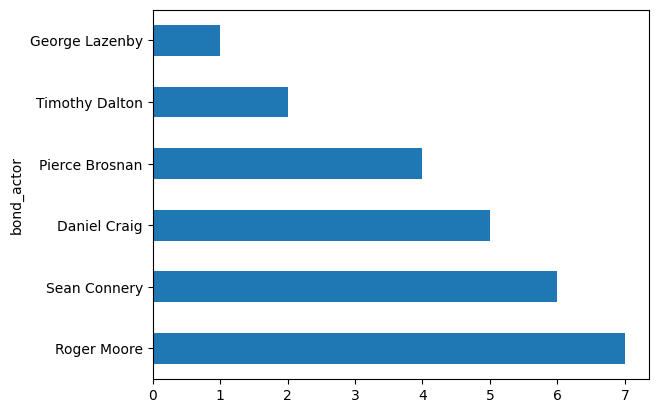

In [16]:
data['bond_actor'].value_counts().plot(kind='barh')

#### Use some different methods for identifying outliers

In [17]:
# Look at all the data
data.describe()

,bond_kills,film_length,imdb,income_usa,income_world,martinis_consumed,movie_budget,release_date,rotten_tomatoes,release_year
count,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25,25.0,25.0
mean,16.88,128.28,6.876,88772516.48,307114711.88,1.08,70608000.0,1986-04-08 16:19:12,6.512,1985.76
min,1.0,106.0,6.0,16067035.0,59567035.0,0.0,1000000.0,1962-06-01 00:00:00,4.7,1962.0
25%,9.0,120.0,6.5,43100000.0,124900000.0,0.0,8000000.0,1971-03-01 00:00:00,6.0,1971.0
50%,14.0,128.0,6.8,54800000.0,187500000.0,1.0,30000000.0,1983-03-01 00:00:00,6.3,1983.0
75%,26.0,133.0,7.2,126930660.0,361730660.0,1.0,110000000.0,1999-06-01 00:00:00,6.9,1999.0
max,47.0,163.0,7.9,304360277.0,1108561108.0,6.0,275000000.0,2021-11-01 00:00:00,8.4,2021.0
std,11.125496,12.940634,0.514198,71266969.584479,276696389.626731,1.28841,85577961.142652,NaN,0.961041,17.847222


film_length, martinis_consumed, movie_budget, and bond_kills have potential outliers.

In [18]:
data[["film_length", "martinis_consumed", "bond_kills", "movie_budget"]].describe()

,film_length,martinis_consumed,bond_kills,movie_budget
count,25.0,25.0,25.0,25.0
mean,128.28,1.08,16.88,70608000.0
std,12.940634,1.28841,11.125496,85577961.142652
min,106.0,0.0,1.0,1000000.0
25%,120.0,0.0,9.0,8000000.0
50%,128.0,1.0,14.0,30000000.0
75%,133.0,1.0,26.0,110000000.0
max,163.0,6.0,47.0,275000000.0


-6 martinis!

We can also do this programmatically for all columns.

In [19]:
# Using standard deviation to find outliers

outlier_counts = {}

for column in data.select_dtypes(include=[np.number]):  # Select only numerical columns
    # Calculate mean and standard deviation
    mean = data[column].mean()
    std_dev = data[column].std()

    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    outlier_count = outliers.shape[0]

    outlier_counts[column] = outlier_count

outlier_counts

{'bond_kills': 0,
 'film_length': 0,
 'imdb': 0,
 'income_usa': 1,
 'income_world': 0,
 'martinis_consumed': 1,
 'movie_budget': 0,
 'rotten_tomatoes': 0,
 'release_year': 0}

In [20]:
# Using the IQR to find outliers

outlier_counts_iqr = {}

for column in data.select_dtypes(include=[np.number]): # Select only numerical columns
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    

    IQR = Q3 - Q1

   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    outlier_count = outliers.shape[0]

   
    outlier_counts_iqr[column] = outlier_count

outlier_counts_iqr

{'bond_kills': 0,
 'film_length': 1,
 'imdb': 0,
 'income_usa': 1,
 'income_world': 3,
 'martinis_consumed': 2,
 'movie_budget': 1,
 'rotten_tomatoes': 1,
 'release_year': 0}

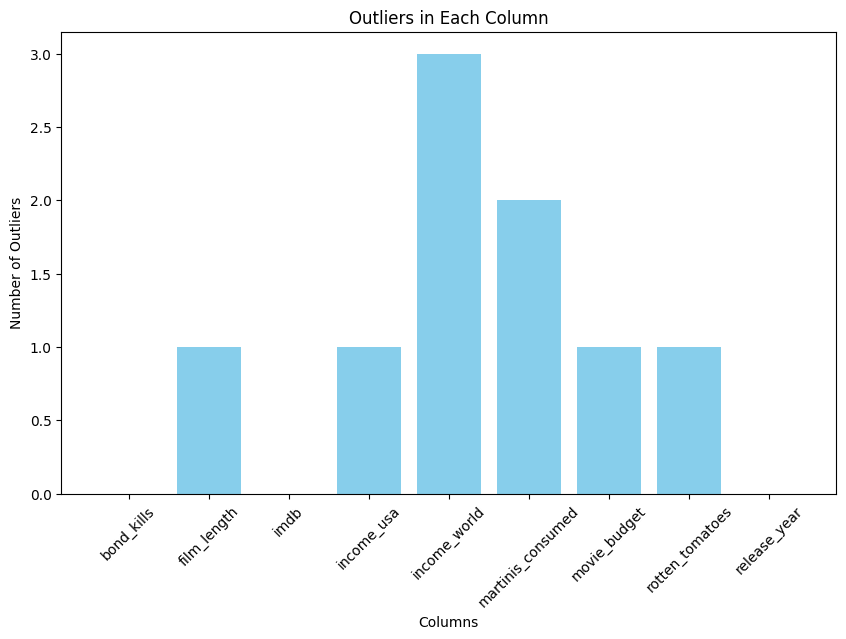

In [21]:
# Convert the outlier counts dictionary to a df
outlier_df = pd.DataFrame(list(outlier_counts_iqr.items()), columns=['Column', 'Outlier Count'])


plt.figure(figsize=(10, 6))
plt.bar(outlier_df['Column'], outlier_df['Outlier Count'], color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.title('Outliers in Each Column')
plt.xticks(rotation=45)
plt.show()


For now, we will fix the outliers in martinis_consumed and film_length. We'll add to the original .assign chaining up top.

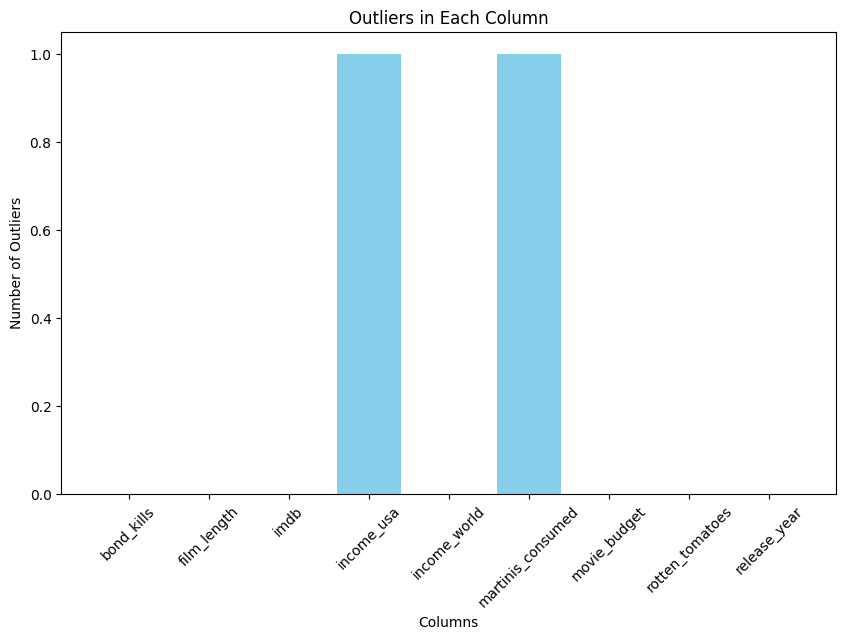

In [22]:
# Plot the standard deviation outliers

outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outlier Count'])


plt.figure(figsize=(10, 6))
plt.bar(outlier_df['Column'], outlier_df['Outlier Count'], color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.title('Outliers in Each Column')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Let's see if we still have -6 martinis consumed!

data[["film_length", "martinis_consumed", "bond_kills", "movie_budget"]].describe()

,film_length,martinis_consumed,bond_kills,movie_budget
count,25.0,25.0,25.0,25.0
mean,128.28,1.08,16.88,70608000.0
std,12.940634,1.28841,11.125496,85577961.142652
min,106.0,0.0,1.0,1000000.0
25%,120.0,0.0,9.0,8000000.0
50%,128.0,1.0,14.0,30000000.0
75%,133.0,1.0,26.0,110000000.0
max,163.0,6.0,47.0,275000000.0


#### Check for duplicates

In [24]:
data.loc[data.duplicated(keep=False)]

,bond_actor,bond_kills,car_manufacturer,film_length,imdb,income_usa,income_world,martinis_consumed,movie_budget,movie_title,release_date,rotten_tomatoes,release_year


All duplicates have been removed!

In [25]:
# Save file now that we have a clean dataset
data.to_csv('data/james_bond_data_clean.csv', index=False)

### Regression analysis

When performing a regression analysis, a good first step is to draw a scatterplot of the two sets of data that you’re analyzing. The shape of this plot gives you a quick visual clue as to the presence of any relationship between them, and if so, whether it’s linear, quadratic or exponential.

Text(0, 0.5, 'Average Rotten Tomatoes Rating')

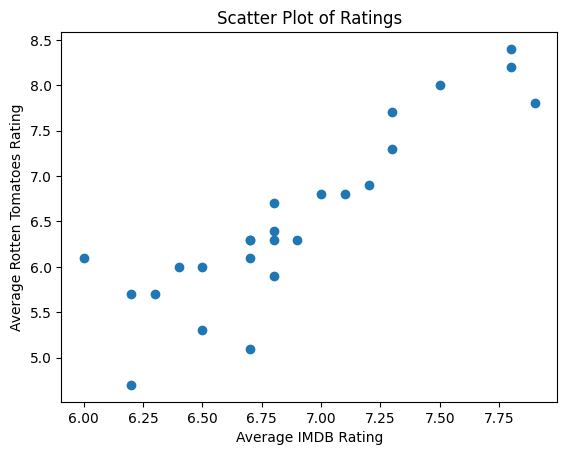

In [37]:
fig, ax = plt.subplots()
ax.scatter(data['imdb'], data['rotten_tomatoes'])
ax.set_title('Scatter Plot of Ratings')
ax.set_xlabel('Average IMDB Rating')    
ax.set_ylabel('Average Rotten Tomatoes Rating')


The scatterplot shows a distinct slope upwards from left to right. This means that as one set of ratings increases, the other set does as well. 

In [27]:
from sklearn.linear_model import LinearRegression

x = data.loc[:, ['imdb']] # create a dataframe with the independent variable by using double brackets
y = data.loc[:, 'rotten_tomatoes'] # create a series with the dependent variable

In [28]:
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [29]:
r_squared = f"R-Squared: {model.score(x, y):.2f}"
best_fit = f"y = {model.coef_[0]:.4f}x{model.intercept_:+.4f}"
y_pred = model.predict(x)

Text(0, 0.5, 'Average Rotten Tomatoes Rating')

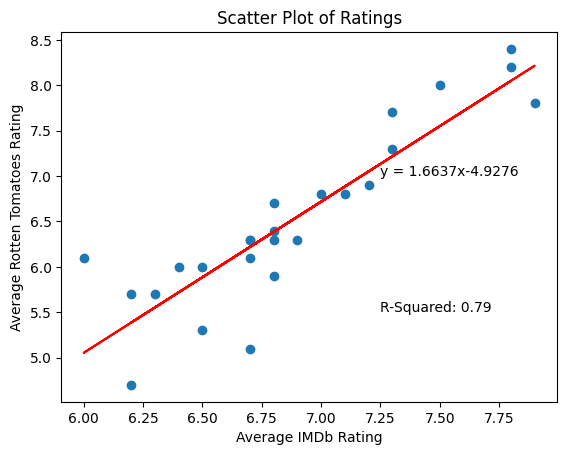

In [36]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, y_pred, color="red")
ax.text(7.25, 5.5, r_squared, fontsize=10)
ax.text(7.25, 7, best_fit, fontsize=10)
ax.set_title("Scatter Plot of Ratings")
ax.set_xlabel("Average IMDb Rating")
ax.set_ylabel("Average Rotten Tomatoes Rating")

### Practice method chaining

In [62]:
# Sample data creation
np.random.seed(0)
data = {
    'date': pd.date_range(start='2022-06-01', periods=365, freq='D'),  # Increased to cover a full year plus
    'product_id': np.random.randint(1, 10, 365),
    'price': np.random.uniform(10, 100, 365),
    'quantity_sold': np.random.randint(1, 5, 365),
}


In [63]:
df = pd.DataFrame(data)
df.head()

,date,product_id,price,quantity_sold
0,2022-06-01,6,14.808446,3
1,2022-06-02,1,75.303493,2
2,2022-06-03,4,11.028471,3
3,2022-06-04,4,79.352267,4
4,2022-06-05,8,23.225198,1


In [57]:
df.shape

(100, 4)

In [64]:
result = (df
          .assign(year=lambda x: x['date'].dt.year)
          .query("year == 2023")
          .assign(total_sales=lambda x: x['price'] * x['quantity_sold'])
          .groupby('product_id')
          .agg(total_sales_sum=('total_sales', 'sum'), total_quantity=('quantity_sold', 'sum'))
          .sort_values('total_sales_sum', ascending=False)
          .reset_index()
         )

In [65]:
result.head()

,product_id,total_sales_sum,total_quantity
0,8,2793.219840,45
1,4,2788.556557,52
2,5,2508.865669,51
3,2,2449.416256,36
4,7,2164.600116,36


In [66]:
print(result)

   product_id  total_sales_sum  total_quantity
0           8      2793.219840              45
1           4      2788.556557              52
2           5      2508.865669              51
3           2      2449.416256              36
4           7      2164.600116              36
5           6      2100.647044              36
6           1      2003.212236              41
7           3      1992.929799              35
8           9      1895.083886              41
